# Audience judgements of motion

Consider how participants moved during the concert and how these compare to their ratings of their own and each others (neighbours) movements during music listening.

1. Pull up the motion measurements and segment per piece (remote and hall?)
2. Pull up Questionnaire responses about how they moved
3. Check summary stats on movement behaviour relative to ratings per question
4. Rank motion by participants, can we see what a lot of movement looks like, vs a little?

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import pingouin as pg

In [8]:
def nannotime(row,shift,dshift):
    # function to generate a row of nans with caveats for time fields, which are shifted by a designated ammount 
    r = row.copy()
    cols = r.index
    for c in cols:
        if not c.startswith('time'):
            if not c.startswith('datetime'):
                r[c] = np.nan
            if c.startswith('datetime'):
                r[c] = r[c] + dshift  
        if c.startswith('time'):
            r[c] = r[c] + shift     
    return r

def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # gap_T is in milliseconds (ms)
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    
    data = data.append(nannotime(data.iloc[-1,:],deltat,dtdeltat),ignore_index=True)
    
    dt = data[time_col].diff()
    a = list(dt[dt>gap_t].index)
    a.sort(reverse=True)
    for gapi in a:
        data = data.append(nannotime(data.iloc[gapi-1,:],deltat,dtdeltat))
        data = data.append(nannotime(data.iloc[gapi,:],-deltat,dtdeltat))

    data = data.append(nannotime(data.iloc[0,:],-1,dtdeltat)).sort_values(time_col,ignore_index=True)
    return data

In [6]:
general_loc = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/'

public_mlmotion = general_loc + 'Public/Motion_ML/'
public_ax3 = general_loc +  'Public/Motion_AX3/'
public_Part = general_loc + 'Public/Participants/'
public_time = general_loc + 'Public/Timing/'

In [173]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)

# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')

concert_times = pd.read_csv(public_time +'Events_Main.csv',",") #SV alignment for beeps
concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

concert_times = pd.read_csv(public_time +'Events_Full.csv',",") #SV alignment for beeps
concert_times['sequence'] = concert_times.index
concert_times.set_index('Datetime',inplace = True)
concert_times.iloc[:5]

,Time_s,Time_ms,Event,Event_Type,Time_Stream,sequence
Datetime,,,,,,
2021-10-26 17:36:35,-691.24,-691240,Clapping,Audience Action,946.00,0
2021-10-26 17:36:52,-674.12,-674120,Clapping Off,Audience Action,963.12,1
2021-10-26 17:36:53,-673.12,-673120,Danish,Speech,964.12,2
2021-10-26 17:37:10,-656.12,-656120,English,Speech,981.12,3
2021-10-26 17:37:20,-645.60,-645600,Danish,Speech,991.64,4


In [13]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
# need only participants with aligned motion traces and questionnair responses
partDets = partDets.loc[partDets['Questionnaire_Language'].isin(['D','E']),:] # participants with at least some questionnaire responses
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts

,Participant_Code,Participant_Number,Attendance,Questionnaire_Language,Motion_Quality,Link_Conflicts,Seat_Zone,Location,Longitude_Truncated,Lattitude_Truncated,Offset_1,Offset_2,Watch_Alone
0,ADQ001,1,A,D,Q,0,6.0,NaN,NaN,NaN,0.14,0.16,0.0
1,ADQ002,2,A,D,Q,0,3.0,NaN,NaN,NaN,NaN,-0.36,0.0
2,ADQ003,3,A,D,Q,0,2.0,NaN,NaN,NaN,0.88,1.02,0.0
3,ADQ004,4,A,D,Q,0,4.0,NaN,NaN,NaN,0.44,0.62,1.0
4,ADQ005,5,A,D,Q,0,4.0,NaN,NaN,NaN,0.04,0.12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,BEQ115,115,B,E,Q,0,NaN,Porto,41.0,-9.0,-6.32,NaN,1.0
108,BEQ116,116,B,E,Q,0,NaN,Montréal,46.0,-74.0,-30.66,NaN,1.0
109,BEQ117,117,B,E,Q,0,NaN,Stockholm,59.0,17.0,-10.22,NaN,1.0
110,BEQ118,118,B,E,Q,0,NaN,Portola Valley California,37.0,-122.0,-28.00,NaN,0.0


In [14]:
# load those motion traces 
# warning this takes a long time to process. I should save versions of this data so I don't need to reinterpoalte all the time. 

# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 1000

for i,participant in alignedParts.iterrows():
    part = participant['Participant_Code']
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = gap_nans(inst_d,1000)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
        resampled[col] = f(ts_ct)
        
    # extract 1D accelerometer feature for easy comparison
    # and basic normalisation
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
    if np.nanmedian(b)>0:
        aud_df[part] = b/np.nanmedian(b)
    else:
        aud_df[part] = b/np.nanmean(b)
        
aud_df.index = dt_ct

In [165]:
Near_Rels = pd.read_csv(public_Part + 'ParticipantsNear_Participants_Hall.csv')

# reduce to list of relationships included in the dataset available here
Sub_Rels = Near_Rels.loc[Near_Rels['Participant_Code_1'].isin(aligned_Part_Codes),:]
Sub_Rels = Sub_Rels.loc[Sub_Rels['Participant_Code_2'].isin(aligned_Part_Codes),:].reset_index(drop = True)

### TODO
cut segments to parts each musical work (or set of works)

    cut per movement, not for whole segment, even though questionnairs report on whole segment. 

    Keep a little pre and post silence interval, where possible. 
    
        Not more than a second (?) from sound? or as much as possible?

prepare to cut the questionnaire accordingly.

['2021-10-26 19:41:02', '2021-10-26 19:43:39']


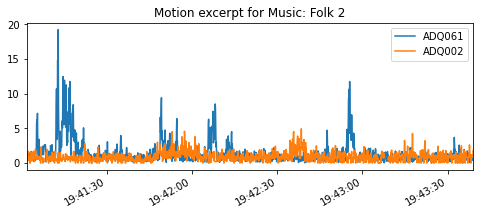

In [20]:
evN = 35
seg_start = Main_concert_times.iloc[evN,:].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = Main_concert_times.iloc[evN+1,:].name
row = Main_concert_times.iloc[evN,:]
print([seg_start,seg_end])

seg_df = aud_df.loc[seg_start:seg_end]
#seg_df = seg_df.loc[:,seg_df.sum()>0]
#seg_df = seg_df.fillna(0)

seg_df.loc[:,['ADQ061','ADQ002']].plot(figsize=[8,3])
plt.xlim([seg_start,seg_end])
plt.title('Motion excerpt for ' + row['Event_Type'] + ': '+ row['Event'])
#plt.savefig('plots/Sample_pair.png',dpi=400)
plt.show()

In [186]:
Main_concert_times['Event_Type'].value_counts()

Applause           17
Speech             16
Music              14
Survey              4
Synchronisation     2
End                 1
Name: Event_Type, dtype: int64

In [200]:
musics = Main_concert_times.loc[Main_concert_times['Event_Type'].str.contains('Music'),:]
Mus_DF = {}
for i,m in musics.iterrows():
    seg_start = m.name
    seg_end = Main_concert_times.loc[Main_concert_times['sequence'] == m['sequence']+1].index[0]
    seg_df = aud_df.loc[seg_start:seg_end]
    seg_df = seg_df.loc[:,seg_df.sum()>0]
    Mus_DF[m['Event']] = seg_df
    
len(Mus_DF)

14

In [208]:
list(Mus_DF)

['Beethoven 1',
 'Beethoven 2',
 'Beethoven 3',
 'Beethoven 4',
 'Schnittke 1',
 'Schnittke 2',
 'Schnittke 3',
 'Bach',
 'Folk 1',
 'Folk 2',
 'Folk 3',
 'Folk 4',
 'Folk 5',
 'Folk 6']

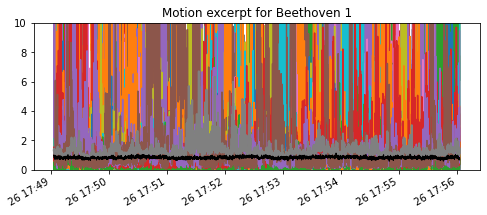

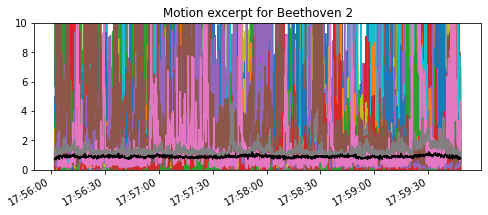

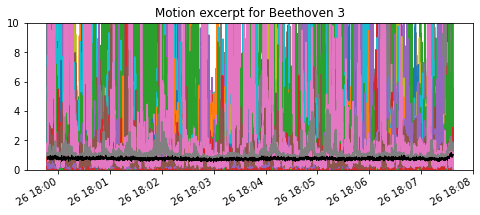

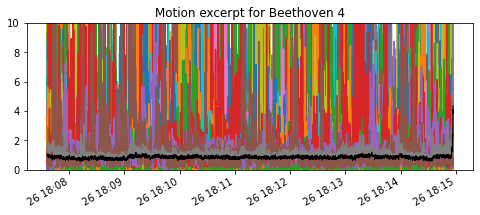

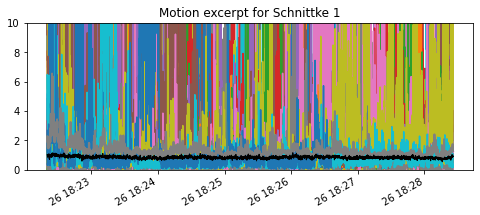

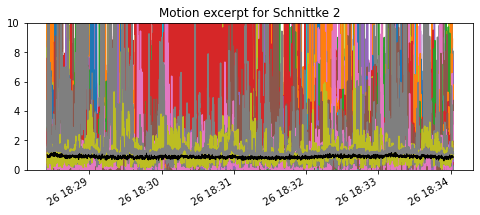

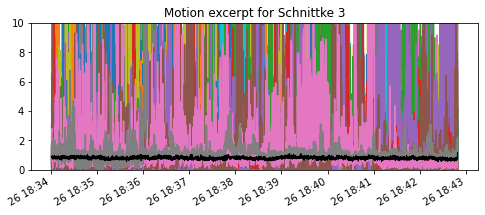

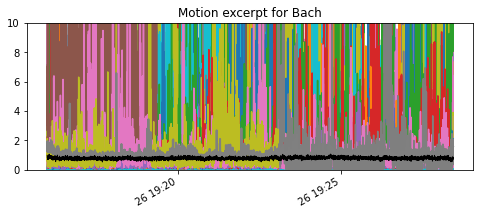

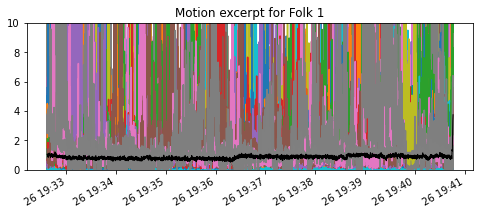

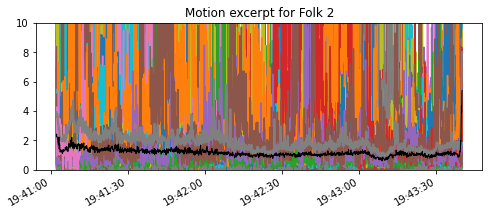

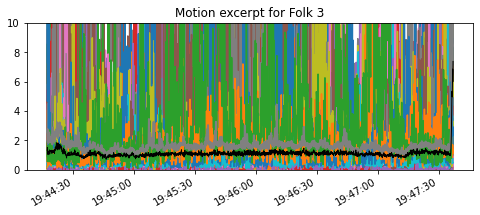

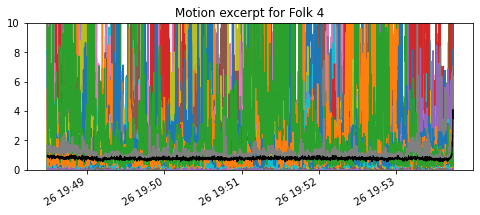

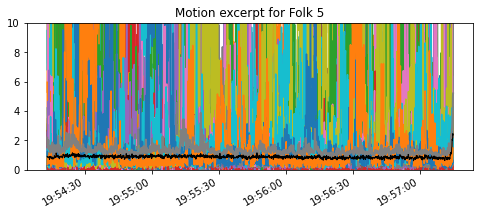

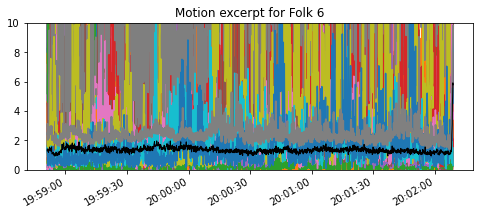

In [215]:
for k,seg in Mus_DF.items():
    seg.plot(figsize=[8,3],legend=False)
    seg.mean(axis=1).plot(color='grey',linewidth=2)
    seg.median(axis=1).plot(color='k',linewidth=1)
    plt.ylim([0,10])
    plt.title('Motion excerpt for ' + k)
    #plt.savefig('plots/Sample_pair.png',dpi=400)
    plt.show()

## Check out questionnair responses

In [130]:
# pull audience questionnair responses
Quest_df = pd.read_csv(public_Part + 'Questionnaire_Responses.csv')
Quest_df = Quest_df.loc[Quest_df['ParticipantCode'].isin(aligned_Part_Codes),:].reset_index(drop = True)
Quest_df

,ParticipantCode,age,gender,musician_status,personal_relation,fan,EC_1,EC_2,EC_3,EC_4,...,changed_behaviour,EC,EC_noTouched,AIMS,KM_Beethoven,KM_Schnittke,KM_Folk,AWE_Beethoven,AWE_Schnittke,AWE_Folk
0,AEQ086,NaN,Woman,Music-loving nonmusician,No_Relation,1.0,3.0,2.0,5.0,2.0,...,NaN,4.000000,4.000000,85,1.4,1.1,1.4,4.333333,4.166667,4.333333
1,AEQ088,NaN,Man,Semiprofessional musician,Relative_Friend,6.0,2.0,3.0,4.0,2.0,...,NaN,3.142857,3.166667,108,2.9,4.2,3.2,4.666667,4.833333,4.666667
2,AEQ077,24.0,Woman,Professional musician,No_Relation,5.0,5.0,1.0,4.0,1.0,...,NaN,4.857143,4.833333,159,4.1,3.9,5.0,4.500000,5.666667,6.333333
3,AEQ081,46.0,Man,Music-loving nonmusician,No_Relation,6.0,4.0,4.0,5.0,3.0,...,NaN,3.714286,3.666667,130,2.8,2.9,4.0,5.500000,6.500000,5.000000
4,AEQ079,71.0,Man,Music-loving nonmusician,No_Relation,7.0,5.0,4.0,4.0,2.0,...,NaN,4.285714,4.166667,141,5.2,3.0,2.6,5.000000,6.000000,5.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,BEQ114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,2.6,2.7,NaN,2.500000,3.333333,NaN
108,BEQ095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,133,4.0,0.6,3.0,3.666667,4.000000,3.666667
109,BEQ115,26.0,Woman,Professional musician,No_Relation,4.0,5.0,2.0,5.0,1.0,...,NaN,4.571429,4.666667,0,3.0,NaN,NaN,3.833333,NaN,NaN
110,BDQ092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,1.8,1.6,NaN,4.166667,4.333333,NaN


In [131]:
Quest_text = pd.read_csv(public_Part + 'Codebook.csv', delimiter=",", encoding='latin-1')
Quest_text

,ID,English_Q,Danish_Q
0,NR,NR,NR
1,userID,userID,userID
2,city,Please specify the city you are streaming from:,Specificér venligst hvilken by du streamer fra
3,viewing_with_others,Are you viewing the concert with anyone you know?,Ser du koncerten med nogen du kender?
4,age,What is your age?,Hvad er din alder?
...,...,...,...
128,AIMS_32,I sometimes close my eyes so I can focus on th...,"Jeg lukker nogle gange mine øjne, så jeg kan f..."
129,AIMS_33,There are times when I will do nothing except ...,Nogle gange laver jeg ikke andet end end at ly...
130,AIMS_34,I sometimes feel like I'm part of something bi...,Jeg føler det nogle gange som om jeg er en del...
131,Comments,If you have any comments or impressions you wo...,Hvis du har nogle kommentarer eller indtryk du...


In [132]:
df = Quest_df
unique_counts = pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
unique_counts

,Column_Name,Num_Unique
4,personal_relation,2
197,language,2
198,group,2
200,viewing_with_others,2
113,negative_Folk,3
...,...,...
215,KM_Folk,46
214,KM_Schnittke,48
1,age,51
212,AIMS,67


In [133]:
print(list(Quest_df.columns))

['ParticipantCode', 'age', 'gender', 'musician_status', 'personal_relation', 'fan', 'EC_1', 'EC_2', 'EC_3', 'EC_4', 'EC_5', 'EC_6', 'EC_7', 'tears_Beethoven', 'chills_Beethoven', 'warm_feeling_Beethoven', 'choked_up_Beethoven', 'refreshed_Beethoven', 'welcoming_Beethoven', 'closeness_Beethoven', 'positive_Beethoven', 'negative_Beethoven', 'tense_Beethoven', 'relaxed_Beethoven', 'alone_Beethoven', 'untouched_Beethoven', 'moved_Beethoven', 'touched_Beethoven', 'admiration_Beethoven', 'presence_grand_Beethoven', 'greater_than_myself_Beethoven', 'jaw_drop_Beethoven', 'gasped_Beethoven', 'challenge_process_Beethoven', 'hard_comprehend_Beethoven', 'others_moved_Beethoven', 'connected_musicians_Beethoven', 'connected_audience_Beethoven', 'enjoy_Beethoven', 'familiar_Beethoven', 'own_world_Beethoven', 'absorbed_music_Beethoven', 'daydream_Beethoven', 'sense_time_Beethoven', 'distracted_Beethoven', 'attentive_Beethoven', 'attention_others_Beethoven', 'attention_sensations_Beethoven', 'positivel

In [134]:
sub_Q_List=['ParticipantCode',
            'aware_body_Beethoven', 'aware_movement_Beethoven', 'aware_others_moving_Beethoven',
            'aware_body_Schnittke', 'aware_movement_Schnittke', 'aware_others_moving_Schnittke',
            'aware_body', 'aware_movement', 'aware_others_moving', # bach
            'aware_body_Folk', 'aware_movement_Folk', 'aware_others_moving_Folk']
sub_Q = Quest_df[sub_Q_List].copy()
sub_Q

,ParticipantCode,aware_body_Beethoven,aware_movement_Beethoven,aware_others_moving_Beethoven,aware_body_Schnittke,aware_movement_Schnittke,aware_others_moving_Schnittke,aware_body,aware_movement,aware_others_moving,aware_body_Folk,aware_movement_Folk,aware_others_moving_Folk
0,AEQ086,Continuously,Yes and I moved less than usual,Yes and they moved less than usual,Continuously,Yes and I moved less than usual,Yes and they moved less than usual,Continuously,Yes and I moved less than usual,Yes and they moved less than usual,Continuously,Yes and I moved less than usual,Yes and they moved a normal amount
1,AEQ088,Intermittently,Yes and I moved a normal amount,Not aware of others movement,Intermittently,Yes and I moved a normal amount,Not aware of others movement,Rarely,Not aware of movement,Not aware of others movement,Rarely,Yes and I moved a normal amount,Not aware of others movement
2,AEQ077,Intermittently,Yes and I moved a normal amount,Not aware of others movement,Rarely,Yes and I moved less than usual,Not aware of others movement,Not at all,Not aware of movement,Not aware of others movement,Intermittently,Yes and I moved more than usual,Yes and they moved a normal amount
3,AEQ081,Intermittently,Yes and I moved a normal amount,Not aware of others movement,Rarely,Yes and I moved less than usual,Not aware of others movement,Intermittently,Yes and I moved a normal amount,Not aware of others movement,Intermittently,Yes and I moved more than usual,Yes and they moved more than usual
4,AEQ079,Continuously,Yes and I moved less than usual,Yes and they moved less than usual,Intermittently,Yes and I moved less than usual,Yes and they moved a normal amount,Intermittently,Yes and I moved less than usual,Yes and they moved less than usual,Intermittently,Yes and I moved less than usual,Yes and they moved less than usual
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,BEQ114,Intermittently,Not aware of movement,Not aware of others movement,Intermittently,Yes and I moved more than usual,Not aware of others movement,NaN,NaN,NaN,NaN,NaN,NaN
108,BEQ095,Intermittently,Not aware of movement,Not aware of others movement,Intermittently,Yes and I moved more than usual,Not aware of others movement,Intermittently,Yes and I moved less than usual,Not aware of others movement,Continuously,Yes and I moved a normal amount,Not aware of others movement
109,BEQ115,Intermittently,Yes and I moved a normal amount,Not aware of others movement,NaN,NaN,NaN,Rarely,Not aware of movement,Not aware of others movement,NaN,NaN,NaN
110,BDQ092,Rarely,Yes and I moved a normal amount,Not aware of others movement,Intermittently,Yes and I moved less than usual,Not aware of others movement,Rarely,Yes and I moved less than usual,Not aware of others movement,NaN,NaN,NaN


<AxesSubplot:>

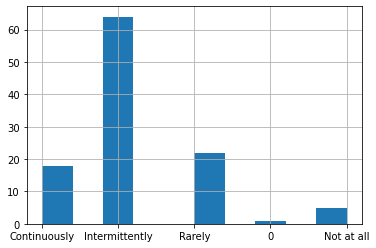

In [136]:
c = 'aware_body_Beethoven'
sub_Q[c].hist()

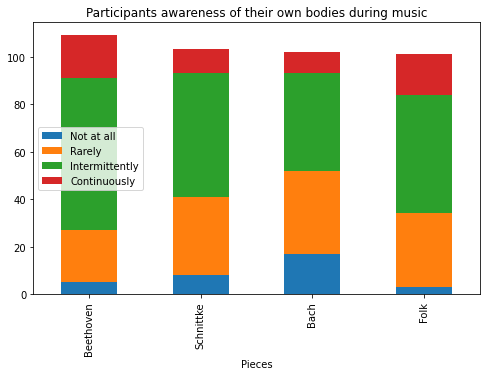

In [150]:
Cols = ['aware_body_Beethoven','aware_body_Schnittke','aware_body','aware_body_Folk']
tracks = ['Beethoven','Schnittke','Bach','Folk']
sub_hist_df = pd.DataFrame(index = Cols, columns = sub_Q[Cols[0]].unique())
for c in Cols:
    sub_hist_df.loc[c] = sub_Q[c].value_counts()

sub_hist_df['Pieces'] = tracks
sub_hist_df.set_index('Pieces',inplace=True,drop = True)
sub_hist_df.drop('0',axis = 1,inplace=True)
sub_hist_df = sub_hist_df.iloc[:,:4]
sub_hist_df = sub_hist_df.loc[:,[ 'Not at all', 'Rarely', 'Intermittently','Continuously']]
#stacked_data = sub_hist_df.apply(lambda x: x*100/sum(x), axis=1)
sub_hist_df.plot(kind='bar',stacked=True,figsize=[8,5])
plt.legend(loc = 'center left')
plt.title('Participants awareness of their own bodies during music')
plt.show()


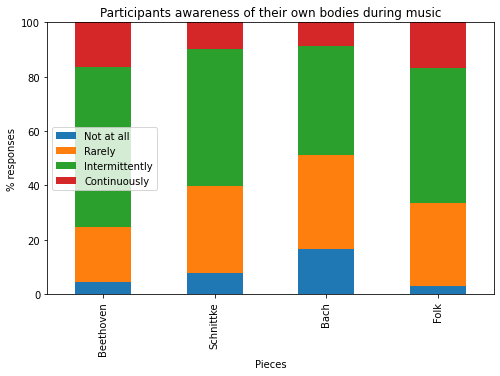

In [161]:
stacked_data = sub_hist_df.apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind='bar',stacked=True,figsize=[8,5])
plt.ylabel('% responses')
plt.ylim([0,100])
plt.legend(loc = 'center left')
plt.title('Participants awareness of their own bodies during music')
plt.show()

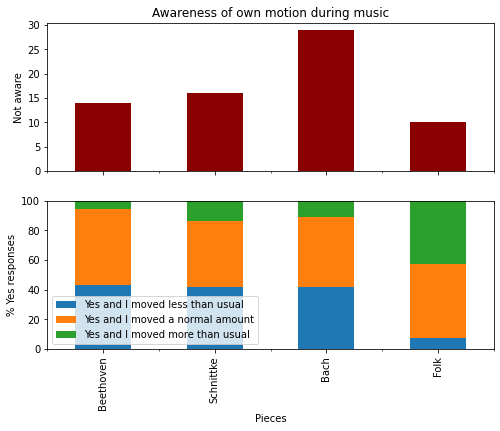

In [163]:
Cols = ['aware_movement_Beethoven','aware_movement_Schnittke','aware_movement','aware_movement_Folk']
tracks = ['Beethoven','Schnittke','Bach','Folk']
sub_hist_df = pd.DataFrame(index = Cols, columns = sub_Q[Cols[0]].unique())
for c in Cols:
    sub_hist_df.loc[c] = sub_Q[c].value_counts()
    
sub_hist_df['Pieces'] = tracks
sub_hist_df.set_index('Pieces',inplace=True,drop = True)
sub_hist_df = sub_hist_df.iloc[:,:4]
sub_hist_df = sub_hist_df.loc[:,['Yes and I moved less than usual', 'Yes and I moved a normal amount','Yes and I moved more than usual','Not aware of movement']]

fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=[8,6])
sub_hist_df.iloc[:,3].plot(kind='bar',color = 'darkred',ax = ax1)
ax1.set_ylabel('Not aware')
ax1.set_title('Awareness of own motion during music')
#sub_hist_df.iloc[:,:3].plot(kind='bar',stacked=True,ax = ax2)

stacked_data = sub_hist_df.iloc[:,:3].apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind='bar',stacked=True,ax = ax2)
ax2.set_ylabel('% Yes responses')
ax2.set_ylim([0,100])
ax2.legend(loc = 'lower left')
plt.show()


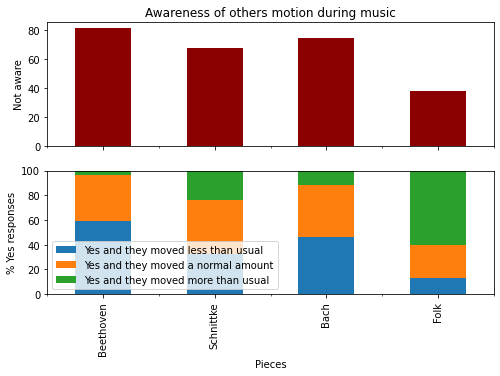

In [164]:
Cols = ['aware_others_moving_Beethoven','aware_others_moving_Schnittke','aware_others_moving','aware_others_moving_Folk']
tracks = ['Beethoven','Schnittke','Bach','Folk']
sub_hist_df = pd.DataFrame(index = Cols, columns = sub_Q[Cols[0]].unique())
for c in Cols:
    sub_hist_df.loc[c] = sub_Q[c].value_counts()
    
sub_hist_df['Pieces'] = tracks
sub_hist_df.set_index('Pieces',inplace=True,drop = True)
sub_hist_df = sub_hist_df.iloc[:,:4]


sub_hist_df = sub_hist_df.loc[:,['Yes and they moved less than usual','Yes and they moved a normal amount',
'Yes and they moved more than usual','Not aware of others movement']]

fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=[8,5])
sub_hist_df.iloc[:,3].plot(kind='bar',color = 'darkred',ax = ax1)
ax1.set_ylabel('Not aware')
ax1.set_title('Awareness of others motion during music')
stacked_data = sub_hist_df.iloc[:,:3].apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind='bar',stacked=True,ax = ax2)
ax2.set_ylabel('% Yes responses')
ax2.set_ylim([0,100])
ax2.legend(loc = 'lower left')
plt.show()

### TODO
cut responses to questionnanre segments re motion

evaluate stats re motion per piece

cut out responses from people who don't have movement recordings (per peice)



In [269]:
# generate a dataframe to combine questionnair results and motion statistics 

# like this example?
A = seg_df.corr(method = 'spearman')
Sub_Rels['Seg_Corr'] = 51
Sub_Rels.loc[Sub_Rels['Distance'] == -2.0,'Distance'] = 2.0

for i,row in Sub_Rels.iterrows():
    Sub_Rels.loc[i,'Seg_Corr'] = A[row['Participant_Code_1']][row['Participant_Code_2']]

In [270]:
pg.anova(dv="Seg_Corr",between = ["Distance","Familiarity"], data=Sub_Rels)

,Source,SS,DF,MS,F,p-unc,np2
0,Distance,0.016339,2.0,0.008170,0.948501,0.388087,0.004161
1,Familiarity,0.000783,1.0,0.000783,0.090919,0.763151,0.000200
2,Distance * Familiarity,0.056252,2.0,0.028126,3.265437,0.039079,0.014181
3,Residual,3.910405,454.0,0.008613,NaN,NaN,NaN


In [272]:
pg.anova(dv="Seg_Corr",between = ["Distance","Familiarity"], data=Sub_Rels)

,Source,SS,DF,MS,F,p-unc,np2
0,Distance,0.016339,2.0,0.008170,0.948501,0.388087,0.004161
1,Familiarity,0.000783,1.0,0.000783,0.090919,0.763151,0.000200
2,Distance * Familiarity,0.056252,2.0,0.028126,3.265437,0.039079,0.014181
3,Residual,3.910405,454.0,0.008613,NaN,NaN,NaN


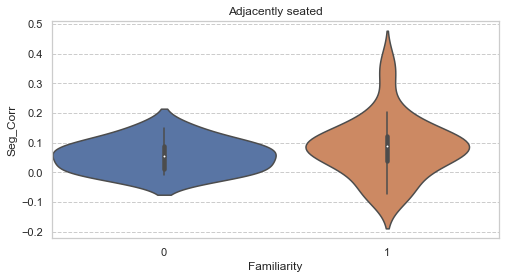

        Source  ddof1  ddof2         F     p-unc      np2
0  Familiarity      1     39  0.780087  0.382527  0.01961


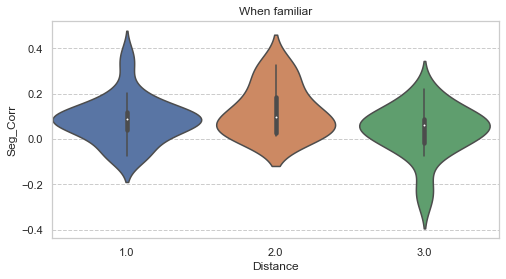

     Source  ddof1  ddof2        F     p-unc       np2
0  Distance      2     61  2.83887  0.066243  0.085152


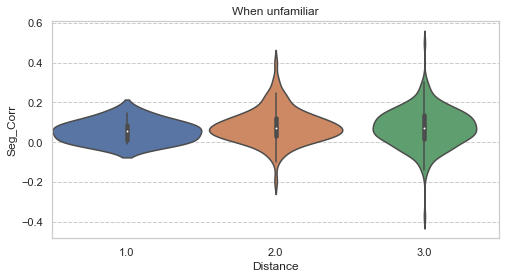

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2    393  0.500615  0.606544  0.002541


In [273]:
Sub_Sub_Rels = Sub_Rels[Sub_Rels['Distance'] == 1.0]
sns.violinplot(x = 'Familiarity',y = 'Seg_Corr',width = 1, data = Sub_Sub_Rels)
plt.title('Adjacently seated')
plt.show()
aov = pg.anova(dv="Seg_Corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)

Sub_Sub_Rels = Sub_Rels[Sub_Rels['Familiarity'] == 1]
sns.violinplot(x = 'Distance',y = 'Seg_Corr',width = 1, data = Sub_Sub_Rels)
plt.title('When familiar')
plt.show()
aov = pg.anova(dv="Seg_Corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

Sub_Sub_Rels = Sub_Rels[Sub_Rels['Familiarity'] == 0]
sns.violinplot(x = 'Distance',y = 'Seg_Corr',width = 1, data = Sub_Sub_Rels)
plt.title('When unfamiliar')
plt.show()
aov = pg.anova(dv="Seg_Corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

In [274]:
concert_times = pd.read_csv(public_time +'Events_Coarse.csv',",") #SV alignment for beeps

# concert_times.drop(concert_times.iloc[61].name,inplace=True)
# concert_times.drop(concert_times.iloc[22].name,inplace=True)
# concert_times.drop(concert_times.iloc[16].name,inplace=True)
concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('datetime')

# replace some of the terms
# event_type Audience Group to Applause, change Clapping to 


In [275]:
Main_concert_times.iloc[:10]

,time_s,time,events,event_type,Stream_Time_s,Event Duration,sequence
datetime,,,,,,,
2021-10-26 17:36:35,-691.24,-691240,Clapping for MC,Applause,946.00,18.12,0
2021-10-26 17:36:53,-673.12,-673120,Speech,MCing,964.12,117.08,1
2021-10-26 17:38:50,-556.04,-556040,Clapping for MC,Applause,1081.20,5.88,2
2021-10-26 17:38:56,-550.16,-550160,Speech,MCing,1087.08,380.52,3
2021-10-26 17:45:16,-169.64,-169640,Clapping for MC,Applause,1467.60,105.96,4
2021-10-26 17:47:02,-63.68,-63680,Speech,MCing,1573.56,63.68,5
2021-10-26 17:48:06,0.00,0,Taps 1,Synchronisation,1637.24,14.38,6
2021-10-26 17:48:20,14.38,14380,Clapping for musicians,Applause,1651.62,43.02,7
2021-10-26 17:49:03,57.40,57400,Beethoven 1,Music,1694.64,418.68,8


In [276]:
corrs_set = pd.DataFrame()
for i in range(len(Main_concert_times)-1):
    als = Sub_Rels.copy()
    row = Main_concert_times.iloc[i]
    if row['Event Duration'] >15:
        seg_start = Main_concert_times.iloc[i].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
        seg_end = Main_concert_times.iloc[i+1].name
        print(str([seg_start,seg_end]) + ': ' + row['events'] + ', ' + row['event_type'])
        corr_name = 'Seg_corr'#
        als['Seg_N'] = row['sequence']
        als['Seg_event'] = row['events']
        als['Seg_type'] = row['event_type']
        als['Seg_dur'] = row['Event Duration']
        als[corr_name] = 0
        seg_df = aud_df.loc[seg_start:seg_end]
        #seg_df = seg_df.fillna(0)
        A = seg_df.corr(method = 'spearman')

        for i,row in Sub_Rels.iterrows():
            if row['Participant_Code_1'] in seg_df.columns:
                if row['Participant_Code_2'] in seg_df.columns:
                    als.loc[i,corr_name] = A[row['Participant_Code_1']][row['Participant_Code_2']]
        corrs_set = pd.concat([corrs_set,als],ignore_index=True)


['2021-10-26 17:36:35', '2021-10-26 17:36:53']: Clapping for MC, Applause
['2021-10-26 17:36:53', '2021-10-26 17:38:50']: Speech, MCing
['2021-10-26 17:38:56', '2021-10-26 17:45:16']: Speech, MCing
['2021-10-26 17:45:16', '2021-10-26 17:47:02']: Clapping for MC, Applause
['2021-10-26 17:47:02', '2021-10-26 17:48:06']: Speech, MCing
['2021-10-26 17:48:20', '2021-10-26 17:49:03']: Clapping for musicians, Applause
['2021-10-26 17:49:03', '2021-10-26 17:56:02']: Beethoven 1, Music
['2021-10-26 17:56:02', '2021-10-26 17:59:47']: Beethoven 2, Music
['2021-10-26 17:59:47', '2021-10-26 18:07:36']: Beethoven 3, Music
['2021-10-26 18:07:36', '2021-10-26 18:14:56']: Beethoven 4, Music
['2021-10-26 18:14:56', '2021-10-26 18:15:28']: Clapping for Beethoven, Applause
['2021-10-26 18:15:28', '2021-10-26 18:15:48']: Speech, MCing
['2021-10-26 18:15:48', '2021-10-26 18:21:19']: Survey for Beethoven, Survey
['2021-10-26 18:21:30', '2021-10-26 18:22:20']: Clapping for Musicians, Applause
['2021-10-26 18:

In [203]:
corrs_set['Distance']= corrs_set['Distance'].abs()

In [221]:
sns.set(rc={'figure.figsize':(7,3)})
sns.set_style("whitegrid", {
    "ytick.major.size": 1,
    "ytick.minor.size": 0.5,
    'grid.linestyle': '--',
    "xtick.major.size": 1,
    "xtick.minor.size": 0.5,
    'grid.linestyle': '--'
 })

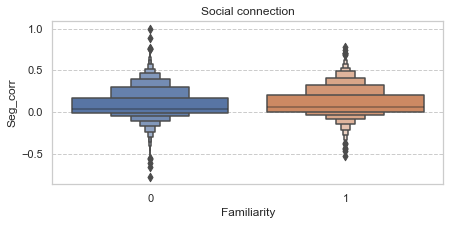

        Source  ddof1  ddof2          F         p-unc       np2
0  Familiarity      1  21378  36.330702  1.692492e-09  0.001697


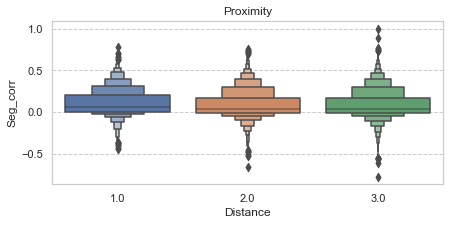

     Source  ddof1  ddof2          F         p-unc       np2
0  Distance      2  21377  14.391377  5.676861e-07  0.001345


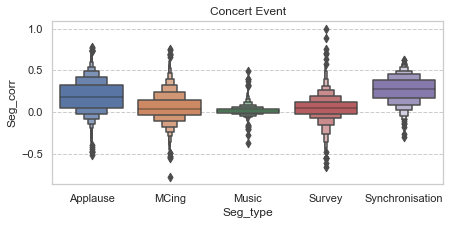

     Source  ddof1  ddof2            F  p-unc       np2
0  Seg_type      4  21375  1519.961304    0.0  0.221449


In [222]:
#sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
#sns.set_theme(style="whitegrid")

sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = corrs_set)
plt.title('Social connection')
plt.savefig('plots/PairCorr_allEvents_Familiarity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=corrs_set)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr', data = corrs_set)
plt.title('Proximity')
plt.savefig('plots/PairCorr_allEvents_Proximity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=corrs_set)
print(aov)

sns.boxenplot(x = 'Seg_type',y = 'Seg_corr', data = corrs_set)
plt.title('Concert Event')
plt.savefig('plots/PairCorr_allEvents_EventType.png',dpi = 400)

plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_type", data=corrs_set)
print(aov)


In [223]:
pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_type'], data=corrs_set)

,Source,SS,DF,MS,F,p-unc,np2
0,Familiarity,0.305635,1.0,0.305635,14.454660,0.000144,0.000677
1,Distance,0.162202,2.0,0.081101,3.835581,0.021604,0.000359
2,Seg_type,128.899240,4.0,32.224810,1524.033631,0.000000,0.222113
3,Familiarity * Distance,0.110526,2.0,0.055263,2.613602,0.073294,0.000245
4,Familiarity * Seg_type,0.272405,4.0,0.068101,3.220762,0.011878,0.000603
5,Distance * Seg_type,0.071650,8.0,0.008956,0.423576,0.907646,0.000159
6,Familiarity * Distance * Seg_type,0.218908,8.0,0.027363,1.294124,0.241188,0.000485
7,Residual,451.433407,21350.0,0.021144,NaN,NaN,NaN


In [225]:
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("whitegrid", {
    "ytick.major.size": 1,
    "ytick.minor.size": 0.5,
    'grid.linestyle': '--',
    "xtick.major.size": 1,
    "xtick.minor.size": 0.5,
    'grid.linestyle': '--'
 })

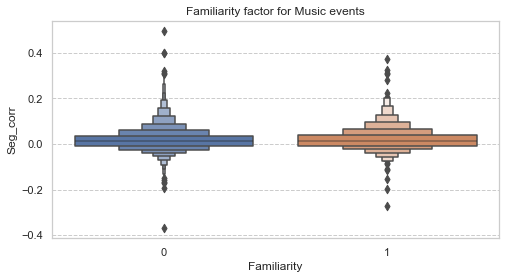

        Source  ddof1  ddof2         F     p-unc       np2
0  Familiarity      1   6718  3.909795  0.048046  0.000582


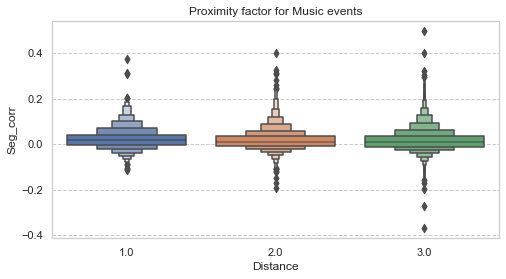

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2   6717  6.503772  0.001507  0.001933


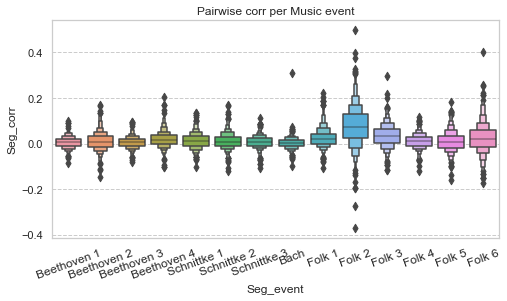

      Source  ddof1  ddof2          F          p-unc      np2
0  Seg_event     13   6706  83.167024  3.608196e-206  0.13884


,Source,SS,DF,MS,F,p-unc,np2
0,Familiarity,0.000136,1.0,0.000136,0.068405,7.936818e-01,0.000010
1,Distance,0.021859,2.0,0.010930,5.492822,4.134950e-03,0.001653
2,Seg_event,2.165829,13.0,0.166602,83.727119,2.354073e-207,0.140910
3,Familiarity * Distance,0.007587,2.0,0.003794,1.906498,1.486813e-01,0.000574
4,Familiarity * Seg_event,0.041308,13.0,0.003178,1.596882,7.814392e-02,0.003119
5,Distance * Seg_event,0.085981,26.0,0.003307,1.661939,1.863138e-02,0.006469
6,Familiarity * Distance * Seg_event,0.081157,26.0,0.003121,1.568697,3.299413e-02,0.006109
7,Residual,13.204473,6636.0,0.001990,NaN,NaN,NaN


In [226]:
# look at within type patters
Ev = 'Music'
Sub_Sub_Rels = corrs_set[corrs_set['Seg_type'] == Ev]


sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = Sub_Sub_Rels)
plt.title('Familiarity factor for ' + Ev + ' events')
plt.savefig('plots/PairCorr_MusicEvents_Familiarity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.title('Proximity factor for ' + Ev + ' events')
plt.savefig('plots/PairCorr_MusicEvents_Proximity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

sns.boxenplot(x = 'Seg_event',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.xticks(rotation='20',fontsize=12)
plt.title('Pairwise corr per ' + Ev + ' event')
plt.savefig('plots/PairCorr_MusicEvents_Peices.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_event", data=Sub_Sub_Rels)
print(aov)

pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_event'], data=Sub_Sub_Rels)

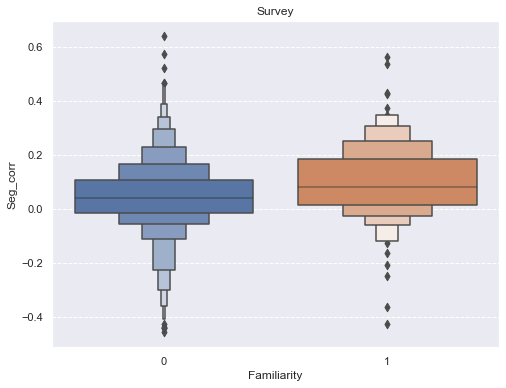

        Source  ddof1  ddof2          F     p-unc       np2
0  Familiarity      1   1343  24.093733  0.000001  0.017624


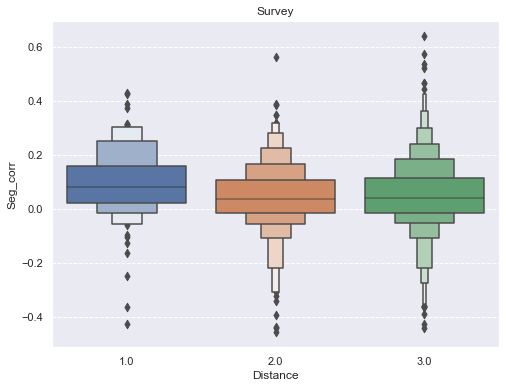

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2   1342  7.158177  0.000809  0.010555


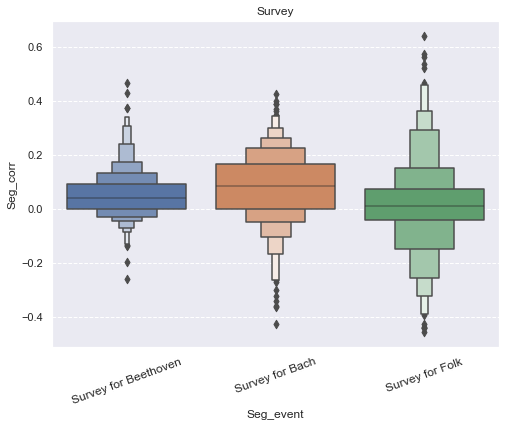

      Source  ddof1  ddof2          F         p-unc       np2
0  Seg_event      2   1342  27.690735  1.642807e-12  0.039632


,Source,SS,DF,MS,F,p-unc,np2
0,Familiarity,0.146430,1.0,0.146430,9.876679,1.710920e-03,0.007388
1,Distance,0.027649,2.0,0.013825,0.932472,3.938371e-01,0.001403
2,Seg_event,0.830461,2.0,0.415230,28.007217,1.219926e-12,0.040502
3,Familiarity * Distance,0.077585,2.0,0.038793,2.616556,7.343088e-02,0.003928
4,Familiarity * Seg_event,0.112846,2.0,0.056423,3.805719,2.248637e-02,0.005703
5,Distance * Seg_event,0.060894,4.0,0.015224,1.026823,3.921092e-01,0.003086
6,Familiarity * Distance * Seg_event,0.373457,4.0,0.093364,6.297395,5.096022e-05,0.018629
7,Residual,19.673882,1327.0,0.014826,NaN,NaN,NaN


In [177]:
# look at within type patters
Ev = 'Survey'
Sub_Sub_Rels = corrs_set[corrs_set['Seg_type'] == Ev]


sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

sns.boxenplot(x = 'Seg_event',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.xticks(rotation='20',fontsize=12)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_event", data=Sub_Sub_Rels)
print(aov)

pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_event'], data=Sub_Sub_Rels)

In [185]:
corrs_set[corrs_set['Seg_event'] == Ev]

,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship,Seg_Corr,Seg_N,Seg_event,Seg_type,Seg_dur,Seg_corr


In [183]:
# look at within type patters
Ev = 'Applause'
Sub_Sub_Rels = corrs_set[corrs_set['Seg_event'] == Ev]


sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

sns.boxenplot(x = 'Seg_N',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.xticks(rotation='20',fontsize=12)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_N", data=Sub_Sub_Rels)
print(aov)

pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_N'], data=Sub_Sub_Rels)

ValueError: min() arg is an empty sequence

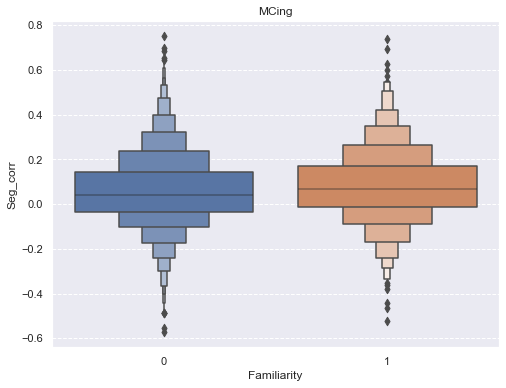

        Source  ddof1  ddof2          F     p-unc       np2
0  Familiarity      1   5582  12.615124  0.000386  0.002255


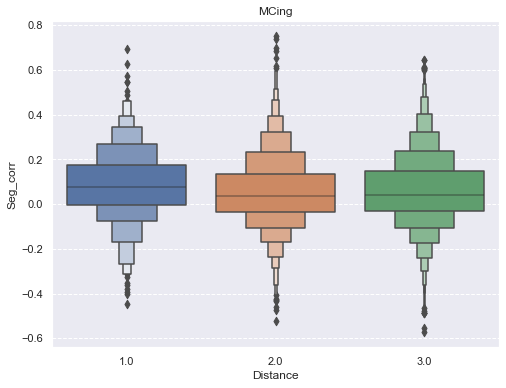

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2   5581  6.614581  0.001351  0.002365


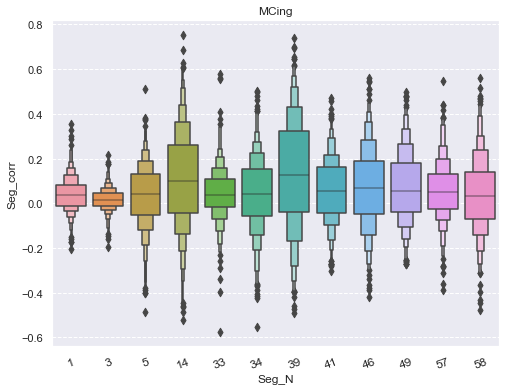

  Source  ddof1  ddof2          F         p-unc       np2
0  Seg_N     11   5572  20.794515  6.402947e-42  0.039433


,Source,SS,DF,MS,F,p-unc,np2
0,Familiarity,0.088744,1.0,0.088744,3.518235,6.074988e-02,0.000638
1,Distance,0.101602,2.0,0.050801,2.014005,1.335513e-01,0.000730
2,Seg_N,5.798593,11.0,0.527145,20.898570,3.861304e-42,0.040036
3,Familiarity * Distance,0.151283,2.0,0.075642,2.998796,4.992840e-02,0.001087
4,Familiarity * Seg_N,0.548136,11.0,0.049831,1.975525,2.675454e-02,0.003927
5,Distance * Seg_N,0.603042,22.0,0.027411,1.086705,3.525430e-01,0.004319
6,Familiarity * Distance * Seg_N,0.588216,22.0,0.026737,1.059988,3.842545e-01,0.004213
7,Residual,139.034493,5512.0,0.025224,NaN,NaN,NaN


In [150]:
# look at within type patters
Ev = 'MCing'
Sub_Sub_Rels = corrs_set[corrs_set['Seg_type'] == Ev]


sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

sns.boxenplot(x = 'Seg_N',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.xticks(rotation='20',fontsize=12)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_N", data=Sub_Sub_Rels)
print(aov)

pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_N'], data=Sub_Sub_Rels)

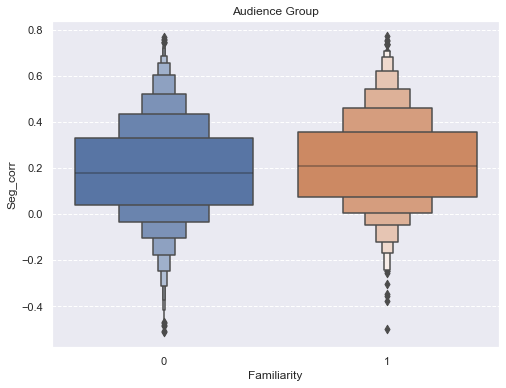

        Source  ddof1  ddof2          F     p-unc       np2
0  Familiarity      1   7010  17.814801  0.000025  0.002535


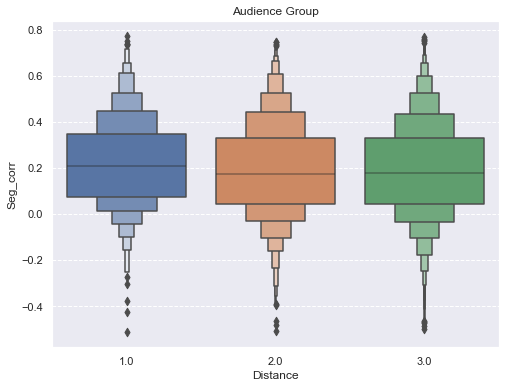

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2   7009  4.677732  0.009329  0.001333


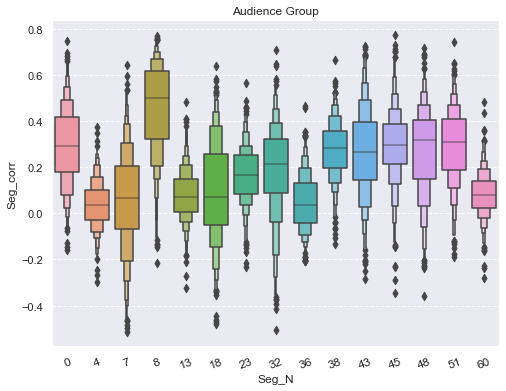

  Source  ddof1  ddof2           F  p-unc       np2
0  Seg_N     14   6997  291.922613    0.0  0.368725


,Source,SS,DF,MS,F,p-unc,np2
0,Familiarity,0.397796,1.0,0.397796,14.750684,0.000124,0.002126
1,Distance,0.036178,2.0,0.018089,0.670756,0.511355,0.000194
2,Seg_N,110.486072,14.0,7.891862,292.638201,0.000000,0.371809
3,Familiarity * Distance,0.164154,2.0,0.082077,3.043505,0.047731,0.000879
4,Familiarity * Seg_N,0.430641,14.0,0.030760,1.140615,0.315575,0.002302
5,Distance * Seg_N,0.705743,28.0,0.025205,0.934631,0.563736,0.003766
6,Familiarity * Distance * Seg_N,0.521445,28.0,0.018623,0.690561,0.887154,0.002786
7,Residual,186.672384,6922.0,0.026968,NaN,NaN,NaN


In [151]:
# look at within type patters
Ev = 'Audience Group'
Sub_Sub_Rels = corrs_set[corrs_set['Seg_type'] == Ev]


sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

sns.boxenplot(x = 'Seg_N',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.xticks(rotation='20',fontsize=12)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_N", data=Sub_Sub_Rels)
print(aov)

pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_N'], data=Sub_Sub_Rels)

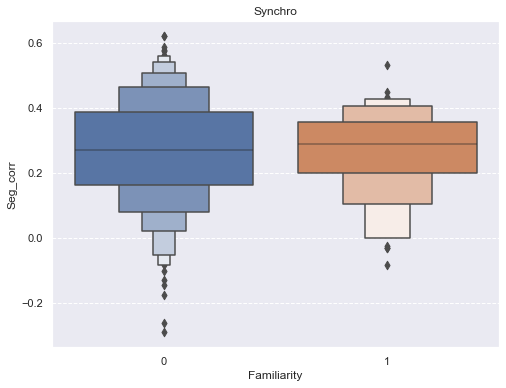

        Source  ddof1  ddof2         F     p-unc       np2
0  Familiarity      1    461  0.063511  0.801143  0.000138


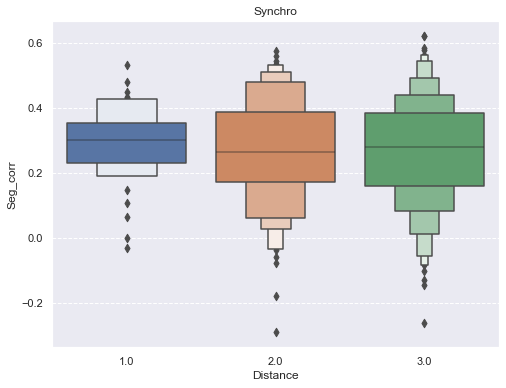

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2    460  0.390087  0.677222  0.001693


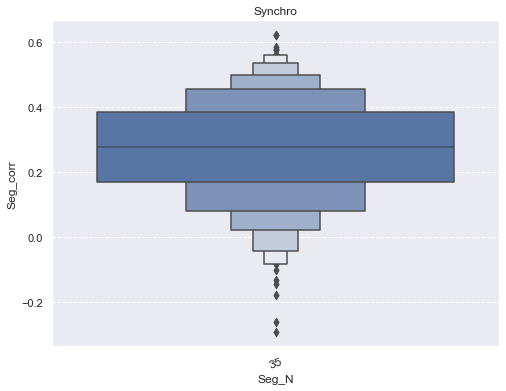

  Source  ddof1  ddof2  np2
0  Seg_N      0    462  0.0


C:\Users\finnu\Anaconda3\lib\site-packages\pingouin\parametric.py:979: RuntimeWarning: invalid value encountered in double_scalars
  msbetween = ssbetween / ddof1


ValueError: must have at least one row in constraint matrix

In [154]:
# look at within type patters
Ev = 'Synchronisation'
Sub_Sub_Rels = corrs_set[corrs_set['Seg_type'] == Ev]


sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

sns.boxenplot(x = 'Seg_N',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.xticks(rotation='20',fontsize=12)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_N", data=Sub_Sub_Rels)
print(aov)

pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_N'], data=Sub_Sub_Rels)